## Confrontiamo e valutiamo i metodi di Decoding
- Utilizza il dataset 'cnn_dailymail' che hai usato in precedenza nelle lezioni pratiche e che ti viene fornito nelle prime celle di questo notebook (utilizza
+un sample di alcune news)
- Carica in memoria il modello T5-small da utilizzare per generare del testo
- Scrivi delle funzioni che vadano a generare del testo utilizzando i diversi metodi di Decoding visti a lezione: Greedy Search, Beam Search, Top-K sampling, Top-P sampling o un insieme di essi.
- Genera dei riassunti delle news utilizzando il modello T5-small e i diversi metodi di decoding
- Calcola le metriche ROUGE e BLEU confrontando i riassunti "Golden Standard" presenti nel dataset con quelli generati dalle diverse metodologie e mettili a confronto


<font color='red'>Va BENISSIMO fare copia-incolla dai notebook precedenti: <br>
&nbsp;&nbsp;&nbsp;&nbsp; → non devi imparare cose a memoria, devi capire come funzionano e sapere dove copiare, cosa modifiare e come! <br>
 Riuscirai a generare dei validi riassunti di news?
</font>

In [ ]:
!pip install datasets
!pip install evaluate
!pip install rouge_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.6 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
from datasets import load_dataset
import evaluate
import matplotlib.pyplot as plt


In [ ]:
cnn_dataset = load_dataset(
    "cnn_dailymail", "3.0.0"
)

#Get just a few news to test
sample_cnn = cnn_dataset["test"].select(range(10))

sample_cnn

Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 10
})

In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model = T5ForConditionalGeneration.from_pretrained('t5-small')
device = "cuda"

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
model.to(device)

In [ ]:
def generate_greedy(input_text, max_lenght):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(device)
    output = model.generate(input_ids, max_length=max_lenght, num_beams=1, early_stopping=True)
    return tokenizer.decode(output[0], skip_special_tokens=True)


In [ ]:
def generate_beam_search(input_text, max_lenght, num_beams=3):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(device)
    output = model.generate(input_ids, max_length=max_lenght, num_beams=num_beams, early_stopping=True)
    return tokenizer.decode(output[0], skip_special_tokens=True)


In [ ]:
def generate_top_k_sampling(input_text, max_lenght, top_k=50):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(device)
    output = model.generate(input_ids, max_length=max_lenght, do_sample=True, top_k=top_k)
    return tokenizer.decode(output[0], skip_special_tokens=True)


In [ ]:
def generate_top_p_sampling(input_text, max_lenght, top_p=0.92):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(device)
    output = model.generate(input_ids, max_length=max_lenght, do_sample=True, top_p=top_p)
    return tokenizer.decode(output[0], skip_special_tokens=True)


In [ ]:
def generate_combined_sampling(input_text, max_lenght, num_beams=3, top_p=0.92):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(device)
    output = model.generate(input_ids, max_length=max_lenght, do_sample=True, num_beams=num_beams, early_stopping=True, top_p=top_p)
    return tokenizer.decode(output[0], skip_special_tokens=True)


In [ ]:
def create_summaries(texts_list, decoding_methods, max_l=125):
    # We are going to add a prefix to each article to be summarized
    # so that the model knows what it should do
    prefix = "Summarize this news: "
    summaries_dict = {}
    texts_list = [prefix + text for text in texts_list]
    for dec_method in decoding_methods:
      summaries_list = [] #Will contain all summaries
      for text in texts_list:
          #Add the summary to summaries list
          if dec_method=="greedy":
            summary = generate_greedy(text, max_l)
          elif dec_method=="beam_search":
            summary = generate_beam_search(text, max_l)
          elif dec_method=="top_k":
            summary = generate_top_k_sampling(text, max_l)
          elif dec_method=="top_p":
            summary = generate_top_p_sampling(text, max_l)
          elif dec_method=="combined":
            summary = generate_combined_sampling(text, max_l)
          summaries_list.append(summary)
      summaries_dict[dec_method] = summaries_list
    return summaries_dict


In [ ]:
decoding_methods = ['greedy', 'beam_search', 'top_k', 'top_p', 'combined']

In [ ]:
max_length = max(len(item['highlights']) for item in sample_cnn)
max_length = max_length + 10


In [ ]:
summaries_dict = create_summaries(sample_cnn["article"],
                                      decoding_methods,
                                      max_l=max_length)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:563: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


In [ ]:
summaries_dict

{'greedy': ['the ICC, the 123rd member of the international criminal court on Wednesday. the ICC officially became the 123rd member of the international criminal court. the ICC is a step that gives the court jurisdiction over alleged crimes in Palestinian territories. the ICC is urging the warring sides to resolve their differences through direct negotiations.',
  ', theia, a friendly white-and-black bully breed mix now named Theia, is receiving care at the Veterinary Teaching Hospital. the dog was found emaciated and dislocated in a field, but survived. the dog is a friendly white-and-black bully breed mix now named Theia.',
  "the Jewish New Year. He is 54, 55 or maybe even 56. Zarif is the opposite number in securing a breakthrough in nuclear talks. he has been u.s. secretary of state John Kerry's opposite number in securing a breakthrough in nuclear talks.",
  ': (CNN)Five Americans who were monitored for three weeks have been released. one of the five had a heart-related issue on 

In [ ]:
summaries_dict['greedy']

['the ICC, the 123rd member of the international criminal court on Wednesday. the ICC officially became the 123rd member of the international criminal court. the ICC is a step that gives the court jurisdiction over alleged crimes in Palestinian territories. the ICC is urging the warring sides to resolve their differences through direct negotiations.',
 ', theia, a friendly white-and-black bully breed mix now named Theia, is receiving care at the Veterinary Teaching Hospital. the dog was found emaciated and dislocated in a field, but survived. the dog is a friendly white-and-black bully breed mix now named Theia.',
 "the Jewish New Year. He is 54, 55 or maybe even 56. Zarif is the opposite number in securing a breakthrough in nuclear talks. he has been u.s. secretary of state John Kerry's opposite number in securing a breakthrough in nuclear talks.",
 ': (CNN)Five Americans who were monitored for three weeks have been released. one of the five had a heart-related issue on Saturday and h

In [ ]:
real_summaries = sample_cnn['highlights']

In [ ]:
bleu = evaluate.load("bleu")
rouge_score = evaluate.load("rouge")


In [ ]:
rouge_scores = {key: rouge_score.compute(
        predictions=summaries_dict[key],
        references=real_summaries) for key in summaries_dict.keys()}

In [ ]:
bleu_scores = {key: bleu.compute(
        predictions=summaries_dict[key],
        references=real_summaries) for key in summaries_dict.keys()}

In [ ]:
bleu_scores

{'greedy': {'bleu': 0.06459326397713161,
  'precisions': [0.2775735294117647,
   0.07677902621722846,
   0.03816793893129771,
   0.021400778210116732],
  'brevity_penalty': 1.0,
  'length_ratio': 1.3300733496332517,
  'translation_length': 544,
  'reference_length': 409},
 'beam_search': {'bleu': 0.0879358904178449,
  'precisions': [0.29927007299270075,
   0.09107806691449814,
   0.056818181818181816,
   0.03861003861003861],
  'brevity_penalty': 1.0,
  'length_ratio': 1.3398533007334963,
  'translation_length': 548,
  'reference_length': 409},
 'top_k': {'bleu': 0.03313760659611631,
  'precisions': [0.24247491638795987,
   0.05102040816326531,
   0.01384083044982699,
   0.007042253521126761],
  'brevity_penalty': 1.0,
  'length_ratio': 1.4621026894865525,
  'translation_length': 598,
  'reference_length': 409},
 'top_p': {'bleu': 0.06566798208487465,
  'precisions': [0.2795275590551181,
   0.09236947791164658,
   0.0430327868852459,
   0.016736401673640166],
  'brevity_penalty': 1.0,


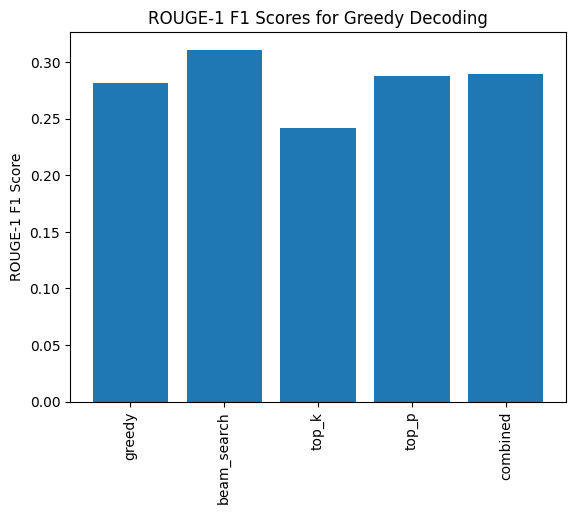

In [ ]:
# Example plot
rouge_1_scores = [score['rouge1'] for score in rouge_scores.values()]

plt.bar(range(len(rouge_1_scores)), rouge_1_scores)
plt.xticks(range(len(rouge_1_scores)), decoding_methods, rotation='vertical')
plt.ylabel('ROUGE-1 F1 Score')
plt.title('ROUGE-1 F1 Scores for Greedy Decoding')
plt.show()


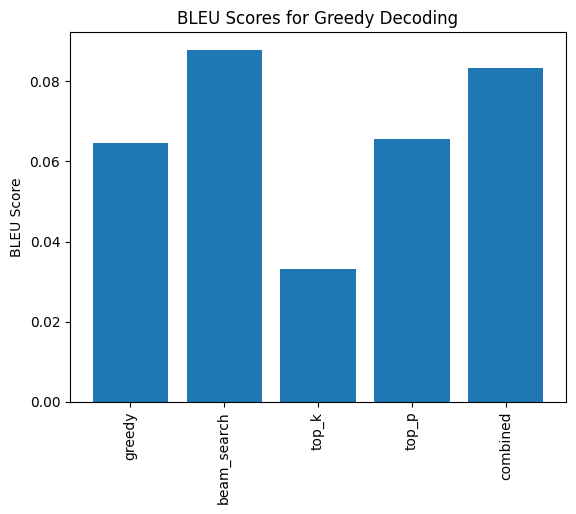

In [ ]:
# Example plot
bleu_ = [score['bleu'] for score in bleu_scores.values()]

plt.bar(range(len(bleu_)), bleu_)
plt.xticks(range(len(bleu_)), decoding_methods, rotation='vertical')
plt.ylabel('BLEU Score')
plt.title('BLEU Scores for Greedy Decoding')
plt.show()
